# Karplus-Strong Algorithm

In [58]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio

In [59]:
plt.rcParams["figure.figsize"] = (18,4)

Set sampling rate for audio

In [60]:
Fs = 16000 # 16KHz

With this sampling rate, since the period of the generated signal is equal to the length of the inital buffer, we will be able to compute the fundamental frequency of the resulting sound. For instance, if we init the K-S algorithm with a vector of 50 values, the buffer will fit $16000 / 50 = 320$ times in a second's worth of samples or, in other words, the resulting frequency will be 320Hz, which corresponds roughly to a E4 on a piano.


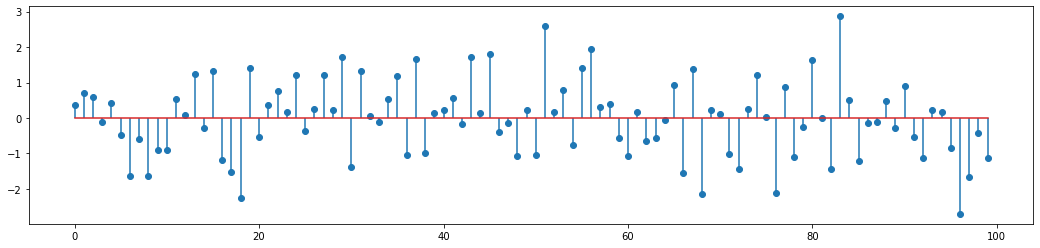

In [61]:
b = np.random.randn(100)
plt.stem(b, use_line_collection=True);

Create a simple Karplus-Strong loop

In [62]:
def KS_1(x, N):
    # given the initial buffer x, produce a N-sample output
    #  by concatenating identical copies of the buffer
    y = x
    while len(y) < N:
        y = np.append(y, x)
    # trim excess
    y = y[0:N+1]
    return y

Generate a audio clip

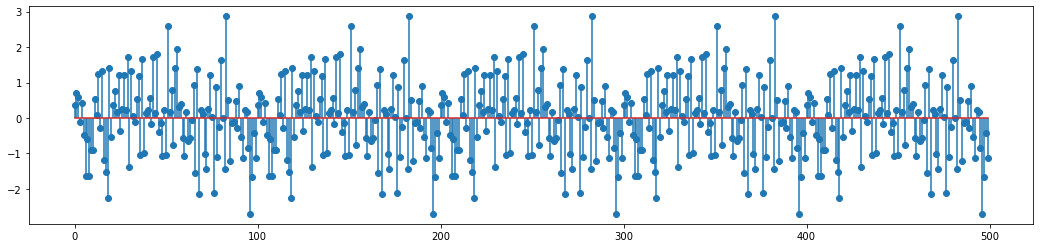

In [63]:
y = KS_1(b, Fs*2)

plt.stem(y[0:500], use_line_collection=True);

In [64]:
Audio(y, rate=Fs)

The output can be expressed as
$$
    y[n] = x[n] + y[n - M]
$$
assuming that the input is the finite-support signal
$$
x[n] = \begin{cases}
    0 & \mbox{for $n < 0$} \\
    b_n & \mbox{for $0 \le n < M$} \\
    0 & \mbox{for $n \ge M$}
  \end{cases}
$$

Let's implement the K-S algorithm as a signal processing loop

In [65]:
def KS_2(x, N):
    # length of the input
    M = len(x)
    # prepare the output
    y = np.zeros(N)
    # this is NOT an efficient implementation, but it shows the general principle
    # we assume zero initial conditions (y[n]=0 for n < 0)
    for n in range(0, N):
        y[n] = (x[n] if n < M else 0) + (y[n-M] if n-M >= 0 else 0)
    return y

In [66]:
Audio(KS_2(np.random.rand(50), Fs * 2), rate=Fs)

By setting $\alpha$ to a value close to but less that one, we can introuce a decay in the note that produces guitar-like sounds:
$$
    y[n] = x[n] + \alpha y[n - M]
$$

In [67]:
def KS_3(x, N, alpha = 0.99):
    M = len(x)
    y = np.zeros(N)
    # 
    for n in range(0, N):
        y[n] = (x[n] if n < M else 0) + alpha * (y[n-M] if n-M >= 0 else 0)
    return y

On plotting, we can see a decaying evelope

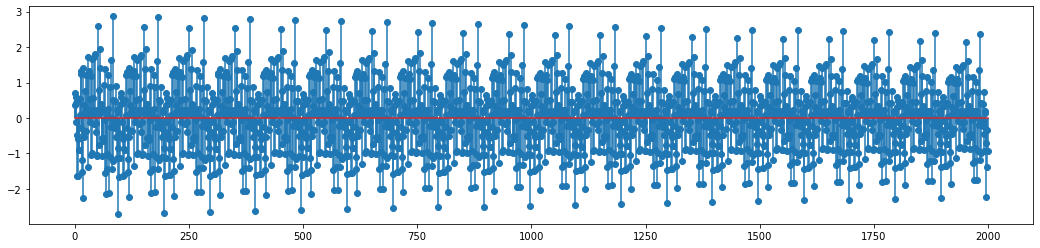

In [68]:
y = KS_3(b, Fs * 2)
plt.stem(y[0:2000], use_line_collection=True);

In [74]:
Audio(y, rate=Fs)

Consider the output of a dampened K-S loop; every time the initial buffer goes through the loop, it gets multiplied by $\alpha$ so that we can write

$$
  y[n] = \alpha^{\lfloor n/M \rfloor}x[n \mod N]
$$

What that means is that the decay envelope is dependent on both $\alpha$ *and* $M$ or, in other words, the higher the pitch of the note, the faster its decay. For instance:

In [75]:
Audio(KS_3(np.random.rand(50), Fs * 2), rate=Fs)

In [76]:
Audio(KS_3(np.random.rand(10), Fs * 2), rate=Fs)

We need to compensate so that, if $\alpha$ is the same, the decay rate is the same. This leads us to the last implementation of the K-S algorithm:

In [77]:
def KS(x, N, alpha = 0.99):
    # we will adjust alpha so that all notes have a decay
    #  comparable to that of a buf len of 50 samples
    REF_LEN = 50
    M = len(x)
    a = alpha ** (float(M) / REF_LEN)
    y = np.zeros(N)
    # 
    for n in range(0, N):
        y[n] = (x[n] if n < M else 0) + a * (y[n-M] if n-M >= 0 else 0)
    return y

In [78]:
Audio(KS(np.random.rand(50), Fs * 2), rate=Fs)

In [79]:
Audio(KS(np.random.rand(10), Fs * 2), rate=Fs)

## Play Music

In [80]:
def freq(note):
    # general purpose function to convert a note  in standard notation 
    #  to corresponding frequency
    if len(note) < 2 or len(note) > 3 or \
        note[0] < 'A' or note[0] > 'G':
        return 0
    if len(note) == 3:
        if note[1] == 'b':
            acc = -1
        elif note[1] == '#':
            acc = 1
        else:
            return 0
        octave = int(note[2])
    else:
        acc = 0
        octave = int(note[1])
    SEMITONES = {'A': 0, 'B': 2, 'C': -9, 'D': -7, 'E': -5, 'F': -4, 'G': -2}
    n = 12 * (octave - 4) + SEMITONES[note[0]] + acc
    f = 440 * (2 ** (float(n) / 12.0))
    #print note, f
    return f


def ks_chord(chord, N, alpha):
    y = np.zeros(N)
    # the chord is a dictionary: pitch => gain
    for note, gain in chord.items():
        # create an initial random-filled KS buffer the note
        x = np.random.randn(int(np.round(float(Fs) / freq(note))))
        y = y + gain * KS(x, N, alpha)
    return y  

In [82]:
# A Hard Day's Night's chord
hdn_chord = {
    'D2' : 2.2, 
    'D3' : 3.0, 
    'F3' : 1.0, 
    'G3' : 3.2, 
    'F4' : 1.0, 
    'A4' : 1.0, 
    'C5' : 1.0, 
    'G5' : 3.5,
}

Audio(ks_chord(hdn_chord, Fs * 4, 0.995), rate=Fs)